In [1]:
!pip install d2l==0.17.2

     |████████████████████████████████| 82 kB 565 kB/s 
     |████████████████████████████████| 20.1 MB 114.4 MB/s 
     |████████████████████████████████| 11.6 MB 54.9 MB/s 
     |████████████████████████████████| 9.9 MB 28.0 MB/s 
     |████████████████████████████████| 61 kB 7.4 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the

In [2]:
pip install matplotlib==3.0.2

     |████████████████████████████████| 12.9 MB 4.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.3
    Uninstalling matplotlib-3.3.3:
      Successfully uninstalled matplotlib-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
d2l 0.17.2 requires matplotlib==3.3.3, but you have matplotlib 3.0.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Some standard techniques for regularizing models.

Limiting the number of features is a popular technique to mitigate overfitting.

##Norms and Weight Decay
The most common method for ensuring a small weight vector
is to add its norm as a penalty term
to the problem of minimizing the loss.
Thus we replace our original objective,
*minimizing the prediction loss on the training labels*,
with new objective,
*minimizing the sum of the prediction loss and the penalty term*.


## High-Dimensional Linear Regression



In [3]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

First, we generate some data as before.

We choose our label to be a linear function of our inputs, corrupted by Gaussian noise with zero mean and standard deviation 0.01. To make the effects of overfitting pronounced, we can increase the dimensionality of our problem to  d=200  and work with a small training set containing only 20 examples.

In [4]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = tf.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## Implementation from Scratch

###Initializing Model Parameters
First, we will define a function to randomly initialize our model parameters.

In [5]:
def init_params():
    w = tf.Variable(tf.random.normal(mean=1, shape=(num_inputs, 1)))
    b = tf.Variable(tf.zeros(shape=(1, )))
    return [w, b]

###Defining  L2  Norm Penalty

In [6]:
def l2_penalty(w):
    return tf.reduce_sum(tf.pow(w, 2)) / 2

###Defining the Training Loop

The following code fits a model on the training set and evaluates it on the test set. We will import the linear network and the squared loss via d2l.linreg and d2l.squared_loss. Our loss now includes the penalty term.

In [7]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                # The L2 norm penalty term has been added, and broadcasting
                # makes `l2_penalty(w)` a vector whose length is `batch_size`
                l = loss(net(X), y) + lambd * l2_penalty(w)
            grads = tape.gradient(l, [w, b])
            d2l.sgd([w, b], grads, lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', tf.norm(w).numpy())

###Training without Regularization

We now run this code with lambd = 0, disabling weight decay. Note that we overfit badly, decreasing the training error but not the test error—a textbook case of overfitting.

L2 norm of w: 18.374573


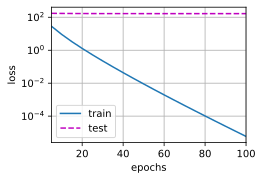

In [8]:
train(lambd=0)

Output of cell [8]:

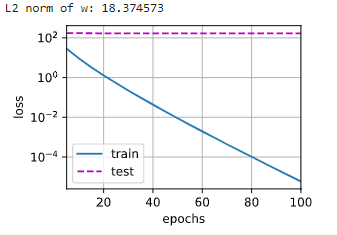

### Using Weight Decay
Below, we run with substantial weight decay. Note that the training error increases but the test error decreases. This is precisely the effect we expect from regularization.

L2 norm of w: 0.5032559


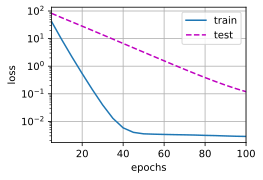

In [9]:
train(lambd=3)

Output of cell [9]:
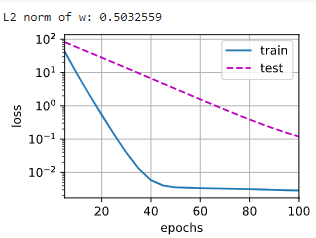

##Concise Implementation

In the following code, we create an  L2  regularizer with the weight decay hyperparameter wd and apply it to the layer through the kernel_regularizer argument.

In [10]:
def train_concise(wd):
    net = tf.keras.models.Sequential()
    net.add(tf.keras.layers.Dense(
        1, kernel_regularizer=tf.keras.regularizers.l2(wd)))
    net.build(input_shape=(1, num_inputs))
    w, b = net.trainable_variables
    loss = tf.keras.losses.MeanSquaredError()
    num_epochs, lr = 100, 0.003
    trainer = tf.keras.optimizers.SGD(learning_rate=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                # `tf.keras` requires retrieving and adding the losses from
                # layers manually for custom training loop.
                l = loss(net(X), y) + net.losses
            grads = tape.gradient(l, net.trainable_variables)
            trainer.apply_gradients(zip(grads, net.trainable_variables))
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', tf.norm(net.get_weights()[0]).numpy())

The plots look identical to those when we implemented weight decay from scratch. However, they run appreciably faster and are easier to implement, a benefit that will become more pronounced for larger problems.

L2 norm of w: 1.343165


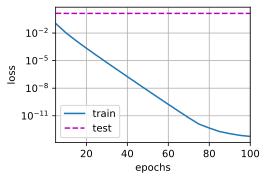

In [11]:
train_concise(0)

Output of cell [11]:
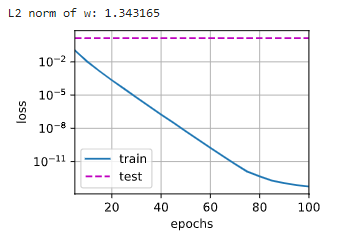

L2 norm of w: 0.037751


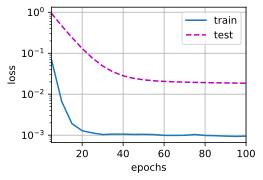

In [12]:
train_concise(3)

Output of cell [12]:
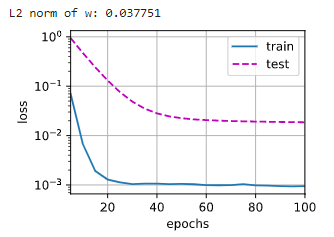

##Summary
Regularization is a common method for dealing with overfitting. It adds a penalty term to the loss function on the training set to reduce the complexity of the learned model.

One particular choice for keeping the model simple is weight decay using an  L2  penalty. This leads to weight decay in the update steps of the learning algorithm.

The weight decay functionality is provided in optimizers from deep learning frameworks.

Different sets of parameters can have different update behaviors within the same training loop.